## Predicción de género 
muela sobre lo q se esta haciendo 


### Paquetes necesarios

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from fairlearn.metrics import demographic_parity_difference as dpd

### Cargando los datos

In [7]:
images = []
genders = []
ages =[]

for i in os.listdir('archive/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('archive/crop_part1/' + i))

images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name= 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images,ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,101,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1


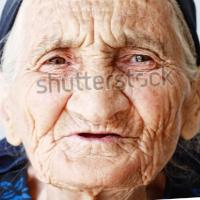

1


In [8]:
display(df['Images'][0])
print(df['Genders'][0])

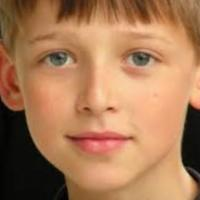

0


In [9]:
display(df['Images'][3])
print(df['Genders'][3])

En los metadatos de las imagenes 0 corresponde a Hombre y 1 a mujer.


### Observando y preparando datos
Aunque lo que se quiere aprender a predecir es el género la edad es un factor importante para equilibrar los datos.  

<Axes: xlabel='Ages', ylabel='Count'>

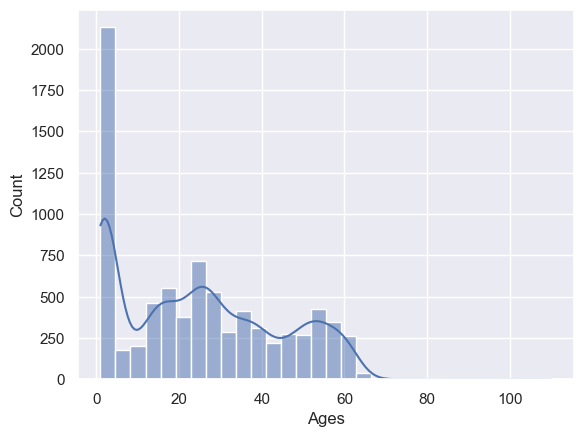

In [10]:
sns.set_theme()
sns.histplot(df['Ages'],kde=True, bins=30)

Por ejemplo vemos que tenemos muchas caras de 0 a 4 años. El modelo se ajustaría a estos dados y no le iría bien con personas de otras edades. Vamos a dejar solo un tercio en este rango de edad como solución.

In [11]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

<Axes: xlabel='Ages', ylabel='Count'>

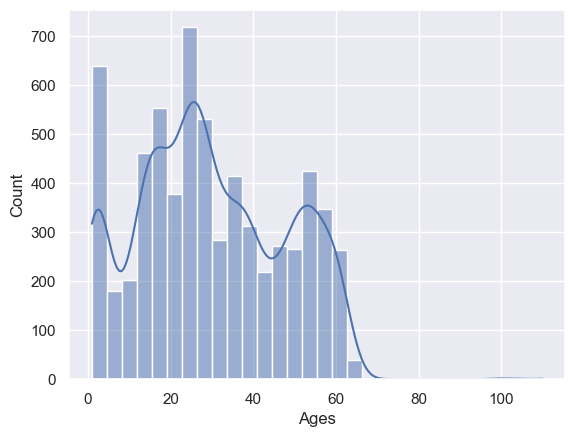

In [12]:
sns.histplot(df['Ages'],kde=True, bins=30)

Esto es mucho más representativo, sin embargo no tenemos muchas imagenes de personas de 60 en adelante por lo q las eliminaremos. 

<Axes: xlabel='Ages', ylabel='Count'>

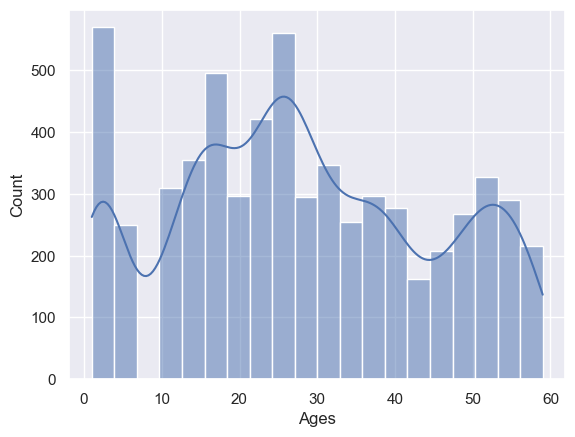

In [13]:
df = df[df['Ages'] < 60]
sns.histplot(df['Ages'],kde=True, bins=20)

<Axes: xlabel='Genders', ylabel='count'>

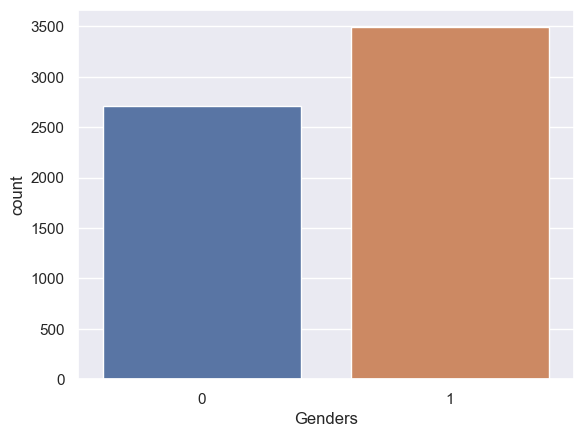

In [14]:
sns.countplot(data = df, x= 'Genders' )

Lo ideal aquí serían igual cantidad de un género que de otro. Igual esta cantidad es factible para el modelo pues la proporcion de los datos con el total es de 45% y 55%. 

In [15]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

C:\Users\lachy\AppData\Local\Temp\ipykernel_19488\2993096863.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
C:\Users\lachy\AppData\Local\Temp\ipykernel_19488\2993096863.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)


### Train Test Split
Dividimos los datos en subconjuntos de entrenamientos y pruebas en proporción 80:20 respectivamente. La semilla aleatoria se establece en 42 para asegurar resultados reproducibles.

In [18]:
y_gender = df['Genders']
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender, random_state=42)

### Creando el modelo 
Utilizaremos un modelo de redes neuronales convolucionales para la clasificacion binaria. Dar mas muela aquí explicando el modelo.

In [16]:
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

c:\Users\lachy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Entrenando el modelo


In [19]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
78/78 [==============================] - 228s 3s/step - loss: 0.6377 - accuracy: 0.6310 - val_loss: 0.5808 - val_accuracy: 0.6817
Epoch 2/50
78/78 [==============================] - 247s 3s/step - loss: 0.5846 - accuracy: 0.6968 - val_loss: 0.5506 - val_accuracy: 0.7019
Epoch 3/50
78/78 [==============================] - 246s 3s/step - loss: 0.5582 - accuracy: 0.7204 - val_loss: 0.5260 - val_accuracy: 0.7317
Epoch 4/50
78/78 [==============================] - 228s 3s/step - loss: 0.5294 - accuracy: 0.7387 - val_loss: 0.4902 - val_accuracy: 0.7575
Epoch 5/50
78/78 [==============================] - 243s 3s/step - loss: 0.5075 - accuracy: 0.7613 - val_loss: 0.4527 - val_accuracy: 0.7905
Epoch 6/50
78/78 [==============================] - 244s 3s/step - loss: 0.4911 - accuracy: 0.7706 - val_loss: 0.4327 - val_accuracy: 0.7929
Epoch 7/50
78/78 [==============================] - 243s 3s/step - loss: 0.4787 - accuracy: 0.7792 - val_loss: 0.4207 - val_accuracy: 0.8002
Epoch 8/50
78

## Métricas


In [43]:
#Precisión por género:
y_preds = genmodel.predict(x_test_gender) 
y_preds = y_preds > 0.5  

precisions = {}
for gender in [0, 1]:
    y_test_gender = y_test_gender == gender  # Mascara de prueba para un genero
    y_pred_gender = y_preds == gender  # Predicciones para ese genero
    
    precisions[gender] = precision_score(y_test_gender, y_pred_gender)
print(precisions)

#Tasas de falsos positivos y falsos negativos por género:
tn, fp, fn, tp = confusion_matrix(y_test_gender, y_pred_gender).ravel()
specificity_score = tn /( tn+ fp)
false_pos_rates = {}
false_neg_rates = {} 
for gender in [0, 1]:
    y_test_gender = y_test_gender == gender  
    y_pred_gender = y_preds == gender  
    
    false_pos_rates[gender] = 1 - specificity_score
    false_neg_rates[gender] = 1 - recall_score(y_test_gender, y_pred_gender)

print(false_pos_rates)
print(false_neg_rates)



39/39 [==============================] - 9s 240ms/step
{0: 0.6182472989195679, 1: 0.0661764705882353}
{0: 0.5450643776824035, 1: 0.5450643776824035}
{0: 0.5450643776824035, 1: 0.45493562231759654}


39/39 [==============================] - 10s 245ms/step


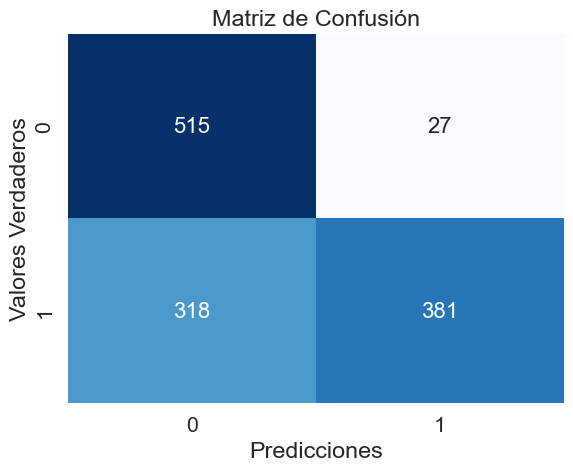

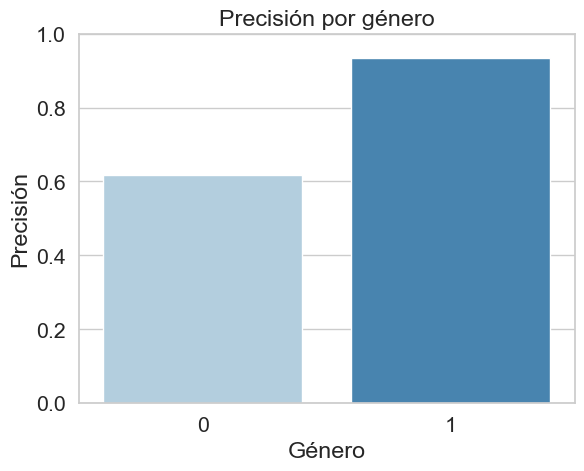

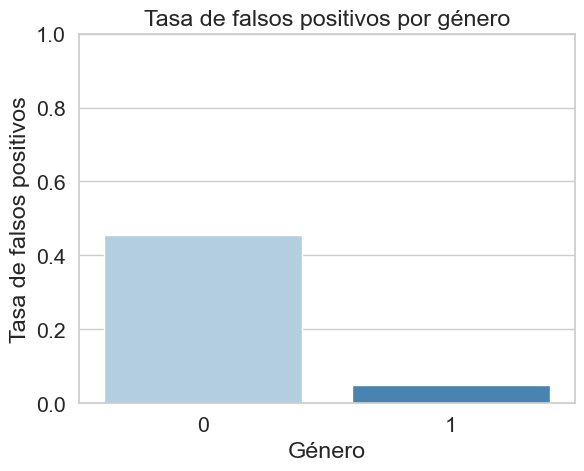

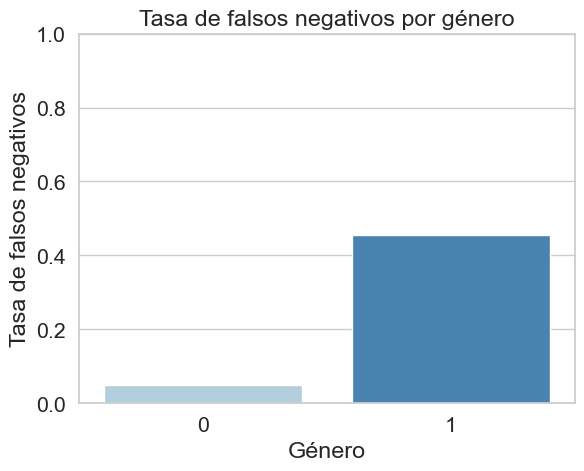

In [48]:
# Obtener predicciones del modelo
y_preds = genmodel.predict(x_test_gender) 
y_preds = y_preds > 0.5

# Obtener matriz de confusión
cm = confusion_matrix(y_test_gender, y_preds)

# Calcular métricas por género
precisions = {}
false_pos_rates = {}
false_neg_rates = {}
sensitivity = {}
specificity = {}
for gender in [0, 1]:
    y_test_gender_mask = y_test_gender == gender
    y_preds_gender_mask = y_preds == gender
    
    precisions[gender] = precision_score(y_test_gender_mask, y_preds_gender_mask)
    
    tn, fp, fn, tp = confusion_matrix(y_test_gender_mask, y_preds_gender_mask).ravel()
    specificity_score = tn / (tn + fp)
    false_pos_rates[gender] = 1 - specificity_score
    false_neg_rates[gender] = 1 - recall_score(y_test_gender_mask, y_preds_gender_mask)
# Graficar matriz de confusión
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

# Graficar precisión por género
sns.set_style("whitegrid")
sns.barplot(x=[0, 1], y=[precisions[0], precisions[1]], palette='Blues')
plt.title('Precisión por género')
plt.xlabel('Género')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.show()

# Graficar tasa de falsos positivos por género
sns.set_style("whitegrid")
sns.barplot(x=[0, 1], y=[false_pos_rates[0], false_pos_rates[1]], palette='Blues')
plt.title('Tasa de falsos positivos por género')
plt.xlabel('Género')
plt.ylabel('Tasa de falsos positivos')
plt.ylim([0, 1])
plt.show()

# Graficar tasa de falsos negativos por género
sns.set_style("whitegrid")
sns.barplot(x=[0, 1], y=[false_neg_rates[0], false_neg_rates[1]], palette='Blues')
plt.title('Tasa de falsos negativos por género')
plt.xlabel('Género')
plt.ylabel('Tasa de falsos negativos')
plt.ylim([0, 1])
plt.show()



### Conclusiones sobre los datos obtenidos en las métricas
Las métricas aplicadas al modelo fueron: 
* Precisión: mide la proporción de predicciones correctas que hizo el modelo. En este caso, la precisión para la clase 0 (masculino) es del 61.8%, lo que significa que el modelo acierta en un poco más del 61% de las veces en las que predice que una imagen es de género masculino. Para la clase 1 (femenino), la precisión es del 93.4%, lo que indica que el modelo acierta en un poco más del 93% de las veces en las que predice que una imagen es de género femenino.

* Matriz de confusión: es una tabla que muestra la cantidad de predicciones correctas e incorrectas que hizo el modelo para cada una de las clases. La posición (0,0) de la matriz indica la cantidad de imágenes de género masculino que fueron clasificadas correctamente, la posición (1,0) indica la cantidad de imágenes de género femenino que fueron clasificadas incorrectamente como masculinas, la posición (0,1) indica la cantidad de imágenes de género masculino que fueron clasificadas incorrectamente como femeninas, y la posición (1,1) indica la cantidad de imágenes de género femenino que fueron clasificadas correctamente.

* Tasa de falsos positivos: es la proporción de imágenes que fueron clasificadas incorrectamente como pertenecientes a la clase 1 (femenino) cuando en realidad pertenecen a la clase 0 (masculino). En este caso, la tasa de falsos positivos para la clase 0 es del 45.5%, lo que significa que el modelo clasifica incorrectamente como femeninas alrededor del 45% de las imágenes que son de género masculino.

* Tasa de falsos negativos: es la proporción de imágenes que fueron clasificadas incorrectamente como pertenecientes a la clase 0 (masculino) cuando en realidad pertenecen a la clase 1 (femenino). En este caso, la tasa de falsos negativos para la clase 0 es del 4.9%, lo que significa que el modelo clasifica incorrectamente como masculinas alrededor del 4% de las imágenes que son de género femenino.

Podemos observar que el modelo clasifica muy bien al género femenino y tiene dificultades con el masculino. El conjunto de datos de entrenamiento utilizado para entrenar el modelo contenía un 55% de imágenes de género femenino y un 45% de imágenes de género masculino. Esto pudo tener un impacto en el rendimiento del modelo, ya que la distribución desigual de las clases en el conjunto de datos(sesgo en el dataset escogido) de entrenamiento podría hacer que el modelo tenga dificultades para aprender a distinguir correctamente entre las dos clases. 

Se hace necesario explorar formas de mejorar el rendimiento del modelo para la clase 0, por ejemplo, mediante la inclusión de más datos de entrenamiento, la optimización de hiperparámetros o el uso de técnicas de aumento de datos.

## Para mi Equipo
Si llegaron hasta aquí pueden recomendarme agregar otras métricas que consideren importantes, tuve que modificar un poco el modelo que escogí pq no me pinchaba(paquetes viejos y un pie q ví). Una propuesta puede ser encapsular estas métricas y análisis para usarlas en cualquier modelo de clasificación binaria y dar unas conclusiones en base a los resultados. Claramente se definirían los parametros que el que vaya a usar esta 'libreria' tiene que pasarnos. Los resultados de estas metricas no son 100% confiables pq shuffle=True y debería ser false si se va a hacer este tipo de análisis(lo que reentrenar demora mucho y lo tuve que hacer como dos veces en la semana). También queda pendiente explicar el modelo pero ya ví en el grupo que no es lo mas importante.  